## 모델 생성

https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchvision.models as models
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torch.optim.lr_scheduler as lr_scheduler

from torch.utils.data import random_split


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
img_dir = "./image/"

In [4]:
transform = v2.Compose(
    [
        v2.Resize(256),
        v2.RandomResizedCrop(224),
        v2.ToImage(),
        v2.ConvertImageDtype(torch.float),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [5]:
img_ds = ImageFolder(root=img_dir, transform=transform)
img_dl = DataLoader(img_ds, batch_size=32, shuffle=True)


In [6]:
print(f"img_ds.classes       : {img_ds.classes}")
print(f"img_ds.class_to_idx  : {img_ds.class_to_idx}")
print(f"img_ds.targets       : {img_ds.targets}")
for img in img_ds.imgs:
    print(f"img_ds.imgs       : {img}")


img_ds.classes       : ['not_top', 'top']
img_ds.class_to_idx  : {'not_top': 0, 'top': 1}
img_ds.targets       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [7]:
# 데이터 분리-> test O
train_size = int(0.8 * len(img_ds))  # 80%
val_size = len(img_ds) - train_size
print(train_size, val_size)


35551 8888


In [8]:
train_dataset, val_dataset = random_split(img_ds, [train_size, val_size])
train_dataset, val_dataset


(<torch.utils.data.dataset.Subset at 0x1e0d0459670>,
 <torch.utils.data.dataset.Subset at 0x1e0d0459af0>)

In [9]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


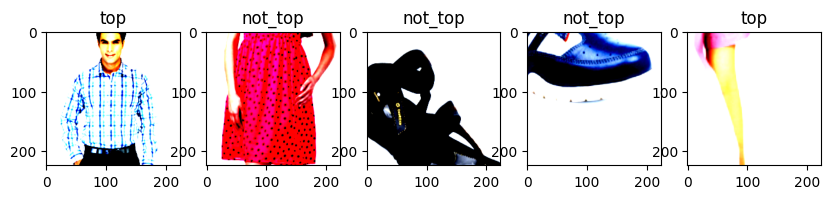

In [10]:
classes = {0: "not_top", 1: "top"}
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for idx, (img_data, target) in enumerate(train_dataset):
    axes[idx].imshow(img_data.permute(1, 2, 0))
    axes[idx].set_title(classes[target])
    if idx == 4:
        break
plt.show()


In [11]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
summary(model)


Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

In [13]:
for named, param in model.named_parameters():
    print(f"[{named}] - {param.shape}")

    param.requires_grad = False


[features.0.0.weight] - torch.Size([32, 3, 3, 3])
[features.0.1.weight] - torch.Size([32])
[features.0.1.bias] - torch.Size([32])
[features.1.0.block.0.0.weight] - torch.Size([32, 1, 3, 3])
[features.1.0.block.0.1.weight] - torch.Size([32])
[features.1.0.block.0.1.bias] - torch.Size([32])
[features.1.0.block.1.fc1.weight] - torch.Size([8, 32, 1, 1])
[features.1.0.block.1.fc1.bias] - torch.Size([8])
[features.1.0.block.1.fc2.weight] - torch.Size([32, 8, 1, 1])
[features.1.0.block.1.fc2.bias] - torch.Size([32])
[features.1.0.block.2.0.weight] - torch.Size([16, 32, 1, 1])
[features.1.0.block.2.1.weight] - torch.Size([16])
[features.1.0.block.2.1.bias] - torch.Size([16])
[features.2.0.block.0.0.weight] - torch.Size([96, 16, 1, 1])
[features.2.0.block.0.1.weight] - torch.Size([96])
[features.2.0.block.0.1.bias] - torch.Size([96])
[features.2.0.block.1.0.weight] - torch.Size([96, 1, 3, 3])
[features.2.0.block.1.1.weight] - torch.Size([96])
[features.2.0.block.1.1.bias] - torch.Size([96])
[fe

In [14]:
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=900),
    nn.Linear(in_features=900, out_features=600),
    nn.Linear(in_features=600, out_features=300),
    nn.Linear(300, 1),
)


In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=10, verbose=True
)


c:\ProgramData\miniconda3\envs\MNV\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [17]:
# 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.classifier.named_parameters():
    print(f"[{named}] - {param.shape}")
    # 역전파 시에 업데이트 되지 않도록 설정
    param.requires_grad = False


[0.weight] - torch.Size([900, 1280])
[0.bias] - torch.Size([900])
[1.weight] - torch.Size([600, 900])
[1.bias] - torch.Size([600])
[2.weight] - torch.Size([300, 600])
[2.bias] - torch.Size([300])
[3.weight] - torch.Size([1, 300])
[3.bias] - torch.Size([1])


In [18]:
for named, param in model.classifier.named_parameters():
    print(f"[{named}] - {param.shape}")
    # 역전파 시에 업데이트 되도록 설정
    param.requires_grad = True


[0.weight] - torch.Size([900, 1280])
[0.bias] - torch.Size([900])
[1.weight] - torch.Size([600, 900])
[1.bias] - torch.Size([600])
[2.weight] - torch.Size([300, 600])
[2.bias] - torch.Size([300])
[3.weight] - torch.Size([1, 300])
[3.bias] - torch.Size([1])


In [19]:
## models 폴더 아래 프로젝트 폴더 아래 모델 파일저장
import os

# 저장 경로
SAVE_PATH = "./models/"
# 저장 파일명
SAVE_FILE = "top_model_train_wbs.pth"
# 저장 모델구조 및 파라미터 모두 저장
SAVE_MODEL = "top_model_all.pth"

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)


In [20]:
for feature, target in train_dl:
    print(feature.shape, target.shape)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [21]:
model.to(DEVICE)

epochs = 1000
loss_history = []
score_history = []

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    train_pred = []
    train_true = []

    for features, targets in train_dl:

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(features.float())
        predicted = torch.round(torch.sigmoid(outputs))
        loss = criterion(outputs, targets.float().view(-1, 1)).to(DEVICE)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        train_pred.extend(predicted.detach().cpu().numpy())
        train_true.extend(targets.detach().cpu().numpy())

    train_f1 = f1_score(train_true, train_pred)
    avg_loss_train = epoch_loss / len(train_dl)

    print(f"EPOCH [{epoch+1}/{epochs}]")
    print(f"[TRAIN] Loss: {avg_loss_train}, Score: {train_f1}")

    loss_history.append(avg_loss_train)
    score_history.append(train_f1)

    # 최적화 스케줄러
    scheduler.step(loss)
    print()
    print(f"scheduler.num_bad_epochs: {scheduler.num_bad_epochs}", end=" ")
    # PyTorch에서 학습률 스케줄러(Scheduler)를 사용할 때, 현재 학습률이 개선되지 않은(epoch의 손실이 향상되지 않은) 연속적인 epoch의 수를 나타내는 변수
    print(f"scheduler.patience: {scheduler.patience}")
    print()

    if len(score_history) == 1:

        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(), SAVE_PATH + SAVE_FILE)

        # 모델 전체 저장
        torch.save(model, SAVE_PATH + SAVE_MODEL)

    else:
        if score_history[-1] >= max(score_history):
            torch.save(model.state_dict(), SAVE_PATH + SAVE_FILE)
            # 모델 전체 저장
            torch.save(model, SAVE_PATH + SAVE_MODEL)

    # 손실 감소(성능 개선) 안 되는 경우 조기 종료
    if scheduler.num_bad_epochs >= scheduler.patience:
        print()
        print(f"{scheduler.patience} EPOCH 성능 개선 없어서 조기 종료")
        break

# 테스트
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for features, targets in val_dl:

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        outputs = model(features.float())
        predicted = torch.round(torch.sigmoid(outputs))
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


EPOCH [1/1000]
[TRAIN] Loss: 0.20608749123781409, Score: 0.8868146584960026

scheduler.num_bad_epochs: 0 scheduler.patience: 10

EPOCH [2/1000]
[TRAIN] Loss: 0.1887977977185221, Score: 0.8978763146140415

scheduler.num_bad_epochs: 0 scheduler.patience: 10

EPOCH [3/1000]
[TRAIN] Loss: 0.17588629848705178, Score: 0.9044311766378296

scheduler.num_bad_epochs: 1 scheduler.patience: 10

EPOCH [4/1000]
[TRAIN] Loss: 0.18442297002726463, Score: 0.9042449773169151

scheduler.num_bad_epochs: 2 scheduler.patience: 10

EPOCH [5/1000]
[TRAIN] Loss: 0.16975532112346373, Score: 0.909238578680203

scheduler.num_bad_epochs: 3 scheduler.patience: 10

EPOCH [6/1000]
[TRAIN] Loss: 0.170505320233344, Score: 0.9063274677937174

scheduler.num_bad_epochs: 4 scheduler.patience: 10

EPOCH [7/1000]
[TRAIN] Loss: 0.1747953227220705, Score: 0.904605396632177

scheduler.num_bad_epochs: 0 scheduler.patience: 10

EPOCH [8/1000]
[TRAIN] Loss: 0.17617960382440706, Score: 0.9050252073507887

scheduler.num_bad_epochs: 

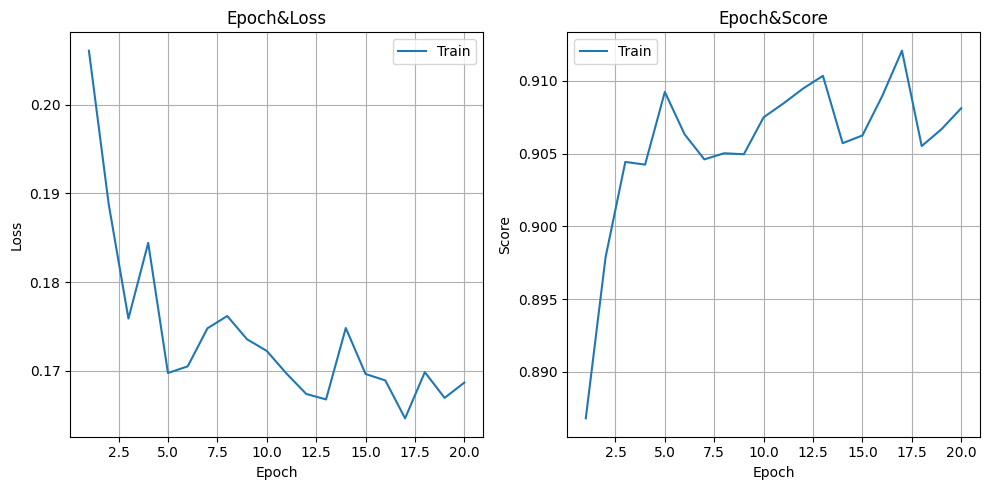

In [22]:
import matplotlib.pyplot as plt

THRESHOLD = len(loss_history)


fg, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(range(1, THRESHOLD + 1), loss_history[:THRESHOLD], label="Train")
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Epoch&Loss")

axes[1].plot(range(1, THRESHOLD + 1), score_history[:THRESHOLD], label="Train")
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Score")
axes[1].set_title(f"Epoch&Score")
plt.tight_layout()
plt.show()
